In [1]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

#선형회귀를 위한  참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

#결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

#VIF 값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [3]:
origin = load_data('sk-diabetes')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")

print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/sk-diabetes.xlsx
[desc] 442명의 당뇨병 환자를 대상으로 한 검사 결과 데이터. 독립변수 표준화 적용됨 (출처: sklearn 내장 데이터)

field    description
-------  -----------------------
age      나이
sex      성별
bmi      bmi지수(비만도)
bp       평균혈압
s1 ~ s6  6종류의 혈액검사 수치
target   당뇨병 진행률(종속변수)


===== 데이터 크기 확인 =====
데이터셋 크기: (442, 11)
열 개수: 11
행 개수: 442

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135


# 종송변수에 영향을 주는 요인 확인

1차 분석 다중선형회귀

In [4]:
df1 = origin.copy()
yname = 'target'

x = df1.drop(yname, axis=1)
y = df1[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           3.83e-62
Time:                        14:52:25   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

분석결과표 위한 함수 정의

In [5]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    Parameters
    ---------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.
    Returns
    ------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    #독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n!="const"]

    #독립변수 부분 데이터(VIF 계산용)
    indi_df = data.filter(xnames)

    #독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        #한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue
        #VIF계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        #유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        #한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,
            "독립변수":name,
            "B":v[1].strip(),
            "표준오차":v[2].strip(),
            "Beta": float(fit.params[name]) * (data[name].std(ddof=1)/data[yname].std(ddof=1)), #표준화 회귀계수
            "t": "%s%s" % (v[3].strip(), stars(p)), #t-통계량(+별표)
            "p-value":p,
            "공차":1/vif,
            "vif":vif,
        })

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in[0,2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    #적합도 보고 문자열 구성
    result_report =  f"𝑅({result_dict['R-squared']}), 𝑅^2({result_dict['Adj. R-squared']}), 𝐹({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"
    #모형 보고 문장 구성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl % ( rdf['종속변수'][0],",".join(list(rdf['독립변수'])),"유의하다" if float(result_dict['Prob (F-statistic)']) <= 0.05 else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<=" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    #변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s % (row['독립변수'],row['B'],
                                     "<=" if float(row['p-value'])<0.05 else '>',
                                     row['종속변수'],
                                     '유의미한' if float(row['p-value'])<0.05 else '유의하지 않은' ))
        return rdf, result_report, model_report, variable_reports

In [20]:
rdf,r,m,v = ols_report(tbl1, df1)
display(rdf)
print(tbl1)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,target,sex,-239.8156,61.222,-0.145633,-3.917***,0.000,0.807833,1.237880
1,target,bmi,519.8459,66.533,0.323399,7.813***,0.000,0.692867,1.443278
2,target,bp,324.3846,65.422,0.201507,4.958***,0.000,0.742260,1.347237
3,target,s3,101.0433,212.531,-0.178581,0.475,0.635,0.685455,1.458885
4,target,s5,751.2737,171.900,0.292961,4.370***,0.000,0.684663,1.460572


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Tue, 13 Jan 2026   Prob (F-statistic):           3.83e-62
Time:                        14:52:25   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

# 2차 분석
vif 값이 가장높은 s1을 제거하고 다시 분석한다.

In [7]:
df2 = df1.drop('s1', axis =1)
yname='target'

x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y,x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df2)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,target,age,-7.9150,59.920,-0.004889,-0.132,0.895,0.821765,1.216892
1,target,sex,-234.1555,61.335,-0.144634,-3.818***,0.000,0.784284,1.275049
2,target,bmi,528.5315,66.577,0.326465,7.939***,0.000,0.665637,1.502320
3,target,bp,319.7634,65.574,0.197512,4.876***,0.000,0.686147,1.457413
4,target,s2,-143.2818,92.922,-0.088503,-1.542,0.124,0.341701,2.926535
5,target,s3,-250.5971,105.002,-0.154790,-2.387*,0.017,0.267602,3.736890
6,target,s4,70.4496,151.883,0.043516,0.464,0.643,0.127899,7.818670
7,target,s5,461.8393,80.068,0.285270,5.768***,0.000,0.460222,2.172865
8,target,s6,69.1270,66.179,0.042699,1.045,0.297,0.673668,1.484410


target에 대하여 age,sex,bmi,bp,s2,s3,s4,s5,s6로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(9,432) = 50.71, p <= 0.05).


# 3차 분석
p-value가 0.05보다 큰 항목을 제거하고 다시 분석

In [8]:
xnames = list(rdf[rdf['p-value']>0.05]['독립변수'])
xnames

['age', 's2', 's4', 's6']

In [9]:
df3 = df2.drop(xnames, axis=1)
df3.head()

,sex,bmi,bp,s3,s5,target
0,0.050680,0.061696,0.021872,-0.043401,0.019907,151
1,-0.044642,-0.051474,-0.026328,0.074412,-0.068332,75
2,0.050680,0.044451,-0.005670,-0.032356,0.002861,141
3,-0.044642,-0.011595,-0.036656,-0.036038,0.022688,206
4,-0.044642,-0.036385,0.021872,0.008142,-0.031988,135


In [10]:
yname = 'target'

x= df3.drop(yname, axis=1)
y = df3[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl3 = fit.summary()

rdf, r, m, v= ols_report(tbl3, df3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,target,sex,-235.7724,60.469,-0.145633,-3.899***,0.0,0.807833,1.237880
1,target,bmi,523.5678,65.293,0.323399,8.019***,0.0,0.692867,1.443278
2,target,bp,326.2311,63.084,0.201507,5.171***,0.0,0.742260,1.347237
3,target,s3,-289.1148,65.646,-0.178581,-4.404***,0.0,0.685455,1.458885
4,target,s5,474.2902,65.683,0.292961,7.221***,0.0,0.684663,1.460572


target에 대하여 sex,bmi,bp,s3,s5로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,436) = 90.26, p <= 0.05).


#

# 잔차 검정
1.선형성 검정

In [11]:
reset_res = linear_reset(fit, power=2, use_f= True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue< 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 3.2149
p-value: 0.0737
선형성 가정 위배 근거 없음 (5% 유의수준)


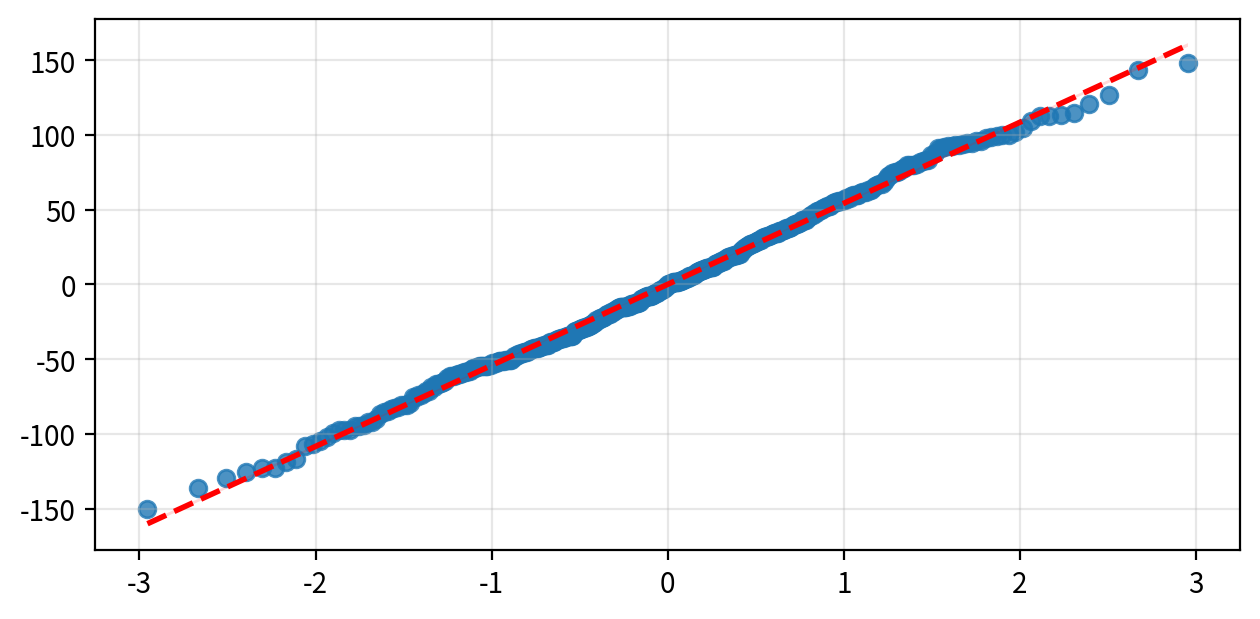

In [12]:
(x,y), _=probplot(fit.resid)

width_px = 1280
height_px = 640
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.regplot( x=x,y=y, line_kws={
    "color": "red",
    "linestyle": "--", 
    "linewidth":2
})


ax.grid(True,alpha =0.3)


plt.tight_layout()
plt.show()
plt.close()

잔차도 시각화

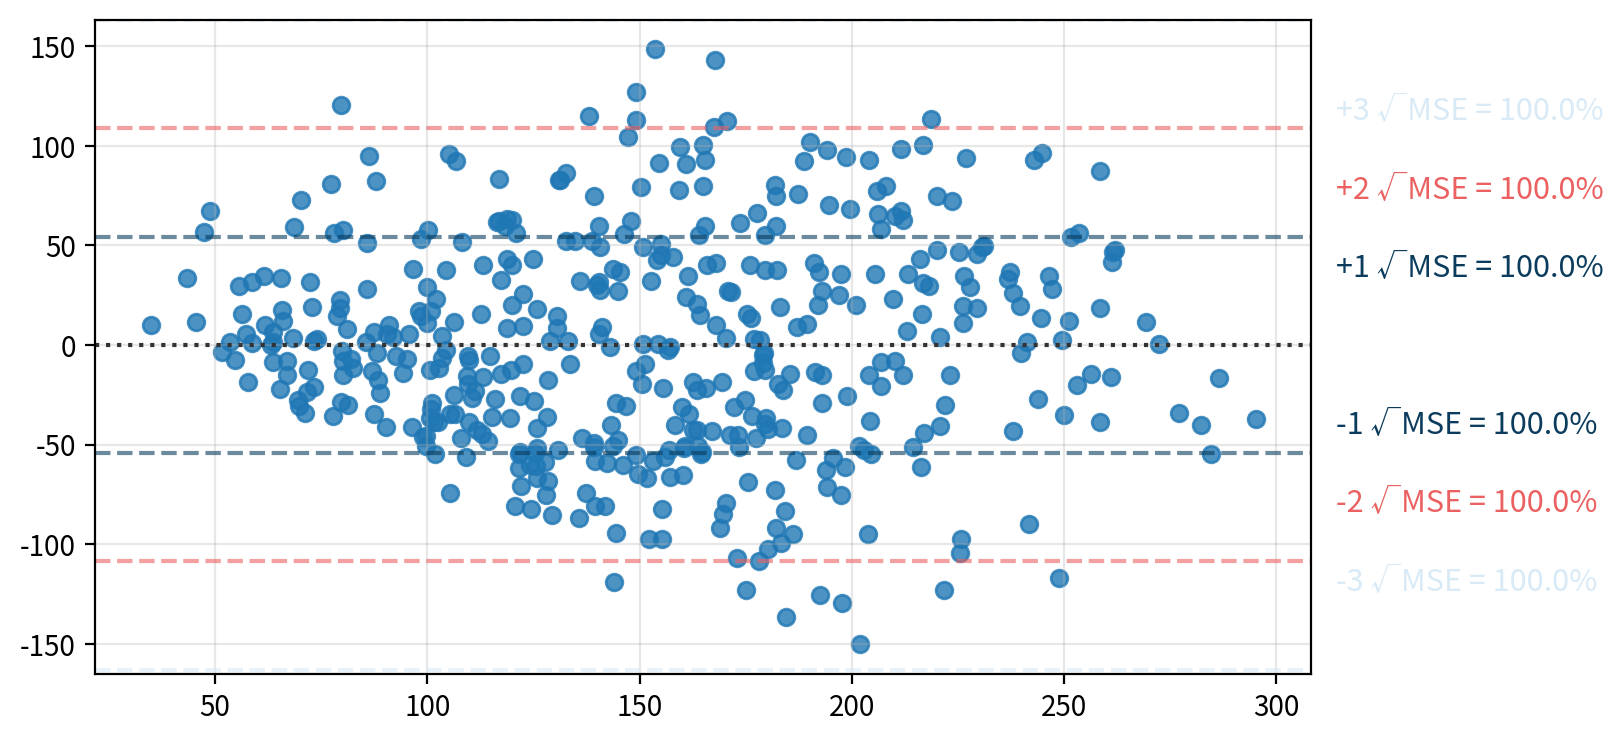

In [13]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid #잔차

r1 = r[ (r >-mse_sq) & (r < mse_sq)].count() / r.count() * 100
r2 = r[ (r >-2*mse_sq) & (r < 2*mse_sq)].count() / r.count() * 100
r3 = r[ (r >-3*mse_sq) & (r < 3*mse_sq)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#EB6161", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px = 1600
height_px = 720
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi= my_dpi, constrained_layout=True)

#seaborn 기본 잔차도
sb.residplot( x=fit.fittedvalues, y=fit.resid)


ax.grid(True,alpha=0.3)

# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
# 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y= y_pos,  color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos,  color=c, linestyle="--", alpha=0.6)
# 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} √MSE = {mse_r[i]}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    ax.text(x=1.02, y=0.5- 0.12*k,
            s=f"-{k} √MSE = {mse_r[i]}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

plt.show()
plt.close()

# 잔차의 정규성 검정
잔차의 정규성이 깨진 경우, 로그/제곱근 등 변환을 고려해야 한다.

In [14]:
if len(origin)<5000:
    method = "Shapiro-Wilk"
    stat, p= shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p<0.05

else:
    method = 'Anderson-Darling'
    ad_res = anderson(fit.resid, dist = 'norm')
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5

print("정규성 가정 위배 가능성이 있음 (5% 유의수준)" if violated else "정규성 가정 위배 근거 없음 (5% 유의수준)")

Shapiro-Wilk statistic: 0.9966, p-value: 0.4663
정규성 가정 위배 근거 없음 (5% 유의수준)


# 잔차의 등분산성
표본 수가 30건보다 클 때 중심극한정리에 따라 잔차의 등분산성이 깨지더라도 분석결과에 큰 영향을 주지 않는다고 가정한다.

In [15]:
#Breusch-Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns = ['value'])

#p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 4.287, p-value = 0.001
이분산성 존재(등분산 아님)


# 잔차의 독립성

In [16]:
dw = durbin_watson(fit.resid)

if 1.5 <= dw <=2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw <1.5:
    interpretation = "잔차에 양의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음의 자기상관이 존재할 가능성이 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 1.990
잔차는 독립성을 만족함 (자기상관 없음)


# 결과보고
1.모형 적합도

In [17]:
m

'target에 대하여 sex,bmi,bp,s3,s5로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,436) = 90.26, p <= 0.05).'

독립변수 보고

In [18]:
print("\n".join(v))

sex의 회귀계수는 -235.7724(p <= 0.05)로, target에 대하여 유의미한 예측변인인 것으로 나타났다.
